# <center> Analyse fréquentielle 

### 1. Préparation du dataset pour l'analyse fréquentielle

##### a. Import du dataset 

On choisit d'utiliser le dataset avec les transformations pertinentes appliquées après exploration des données. Notamment 4 styles avec un nombre insuffisant d'image ont été supprimés pour avoir des classes équilibrées lors de l'apprentissage dans la partie Deep Learning.

In [4]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent
sys.path.append(str(PROJECT_ROOT))
DATA_ROOT = PROJECT_ROOT / "data"

import src.dataset as dataset_module
import src.preprocessing as preprocessing_module

df_test, df_train, df_val = dataset_module.load_df_train_test_val(DATA_ROOT)
df_full = dataset_module.load_df(DATA_ROOT)

print(df_full.shape, df_train.shape, df_val.shape, df_test.shape)

df, df_train, df_val, df_test = preprocessing_module.clean_dataset(
    df_full, df_train, df_val, df_test
)


(9938, 8) (6956, 8) (1491, 8) (1491, 8)


##### b. Ajout des bibliothèques nécessaires

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
import json

import src.frequency_analysis as fa_module
import src.frequency_visualizer as fv_module

from importlib import reload
reload(fa_module);
reload(fv_module);

##### c. On crée un échantillon représentatif 

Pour la partie 2 et 3, nous allons prendre 15 images par style pour avoir une petite base statistique sans avoir des temps de calculs trop longs.  

In [49]:
# On définit le nombre d'images par style pour l'analyse
N_IMAGES_PER_STYLE = 15 

# Création de l'échantillon pour l'analyse statistique (Partie 2 et 3)
df_analysis = df_train.groupby('style_name').sample(n=N_IMAGES_PER_STYLE, random_state=6)

print(f"Échantillon d'analyse créé : {df_analysis.shape[0]} images ({N_IMAGES_PER_STYLE} images/style)")

# Test de la fonction load_image du module dataset
try:
    sample_row = df_analysis.iloc[0]
    img_test = dataset_module.load_image(sample_row, DATA_ROOT)
    print(f"Image test chargée avec succès : {sample_row['filename']} ({img_test.size})")
except Exception as e:
    print(f"Erreur lors du chargement : {e}")



Échantillon d'analyse créé : 345 images (15 images/style)
Image test chargée avec succès : 1806.jpg ((1382, 1382))


### 2. Etude de cas : Analyse Visuelle Comparative

Nous allons voir si l'analyse fréquentielle permet de montrer une différence entre deux styles : 
- contrastés (minimalisme et baroque) 
- plus ambigus (impressionnisme et Post-Impressionisme) 

##### a. Transformé de Fourier

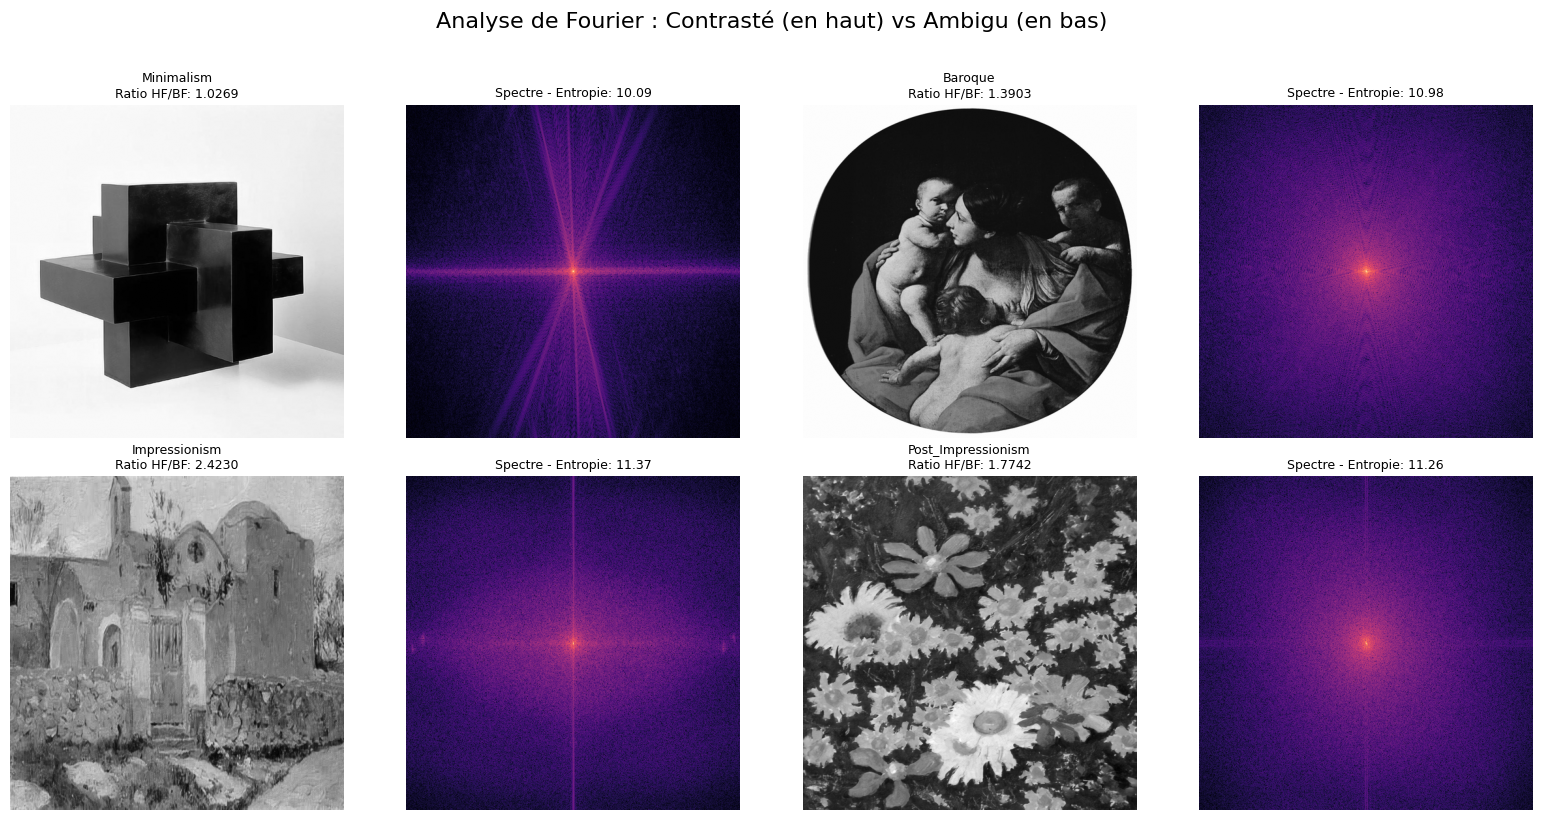

In [50]:
analyzer = fa_module.FrequencyAnalyzer(target_size=(512, 512))

# Styles à comparer
cases = {
    "Contrasté": ["Minimalism", "Baroque"],
    "Ambigu": ["Impressionism", "Post_Impressionism"]
}
target_styles = cases["Contrasté"] + cases["Ambigu"]

# Comparaison Fourier
fv_module.FrequencyVisualizer.plot_comparative_analysis(target_styles, df_analysis, analyzer, dataset_module, DATA_ROOT, mode="fourier");

Le spectre de Fourier 2D décompose l'image par fréquences : le centre contient les formes globales (basses fréquences) et la périphérie contient les détails et textures (hautes fréquences).

Interprétations :

Minimalisme (Croix, centre dense) : L'énergie est concentrée sur les structures géométriques de base. L'absence de lumière hors des croix confirme un style lisse, sans micro-textures.

Baroque (Spectre très dispersé) : La luminosité loin du centre traduit la richesse des détails, des ornements et des contrastes marqués.

Impressionnisme & Post-Impressionnisme (Dispersion et Croix visible) : Les deux styles contiennet des hautes fréquences à cause de la fragmentation des touches. La présence d'une croix centrale indique que la structure globale de la scène reste néanmoins organisée.

La similarité entre les spectres des styles Impressionnisme, Post-Impressionnisme et baroque montre que l'analyse globale de Fourier ne va très certainement pas suffir à distinguer les styles.

##### b. Filtres Passe-Haut/Passe-Bas 

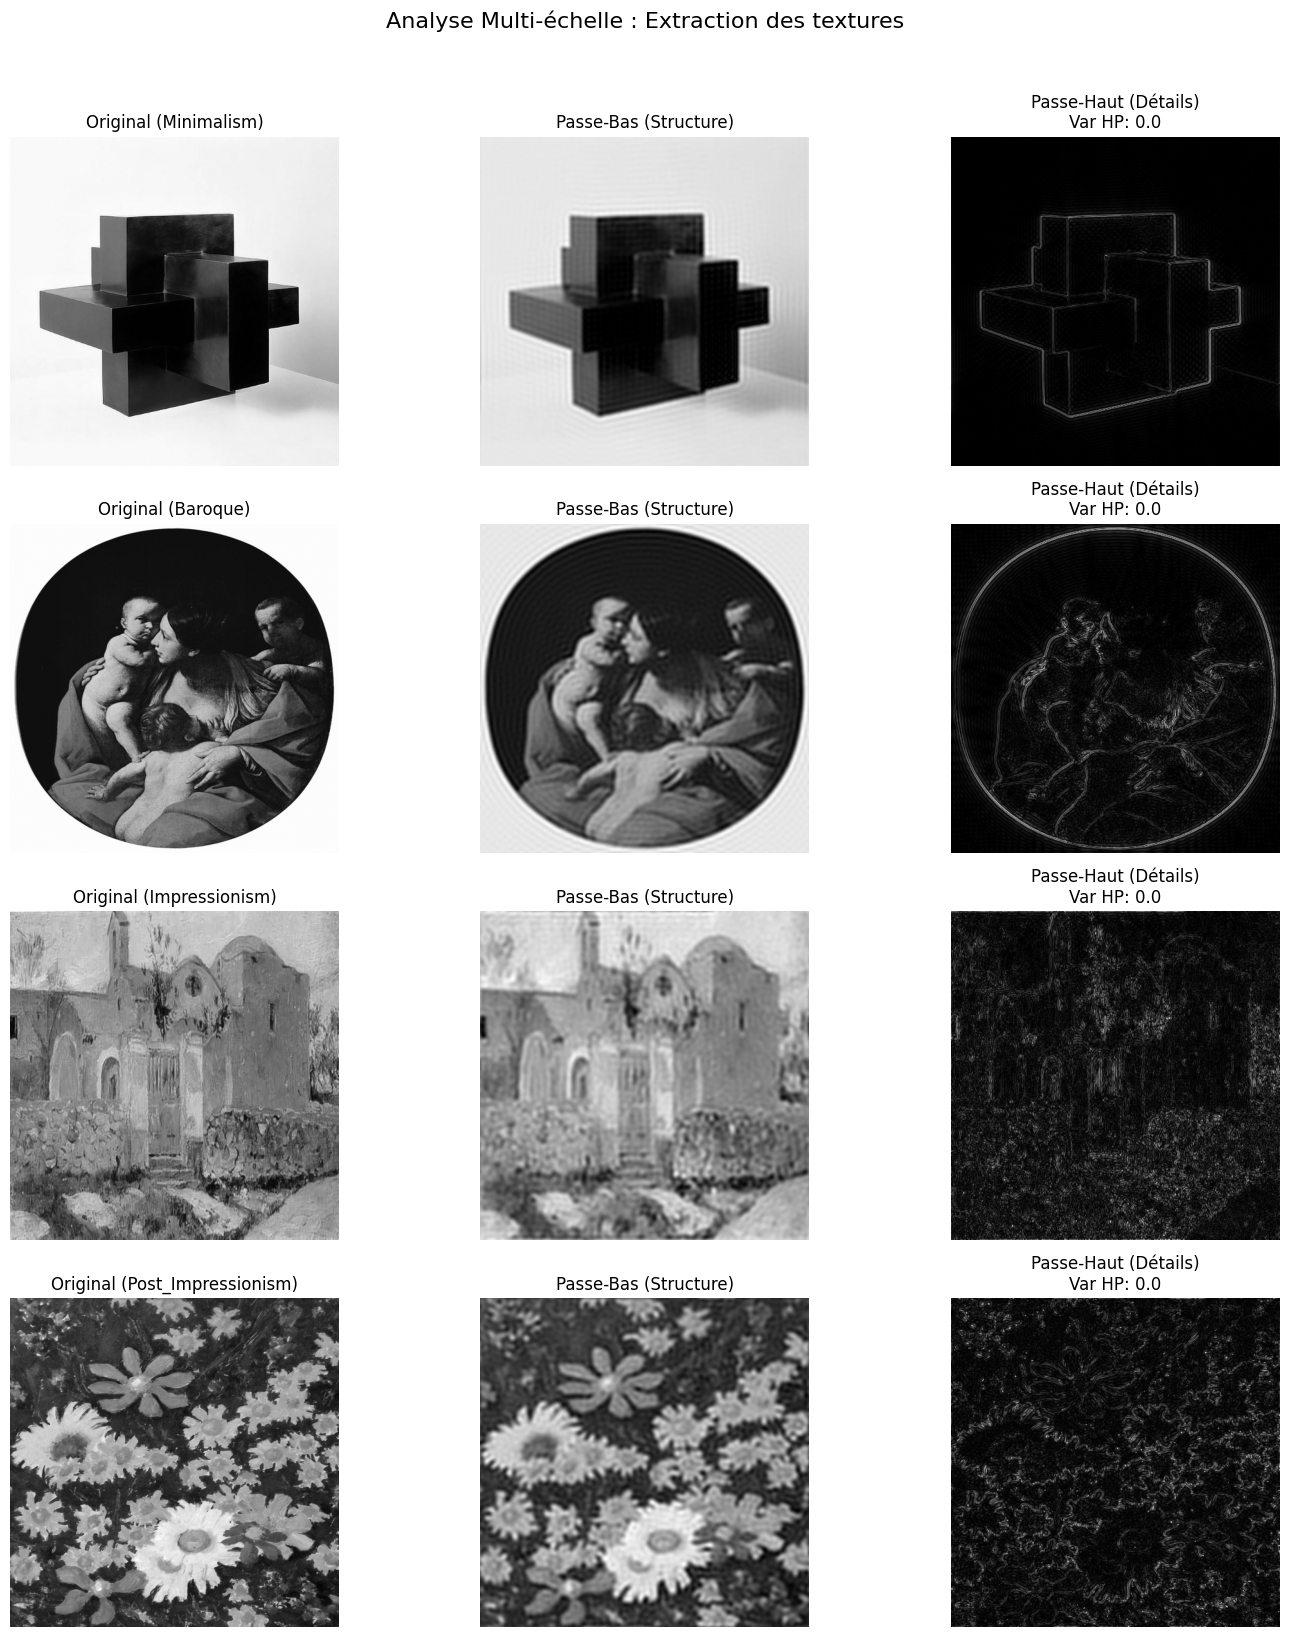

In [51]:
# Comparaison Filtres
fv_module.FrequencyVisualizer.plot_comparative_analysis(target_styles, df_analysis, analyzer, dataset_module, DATA_ROOT, mode="multiscale");

Le filtrage spatial permet d'isoler les informations de l'image selon leur taille et leur contraste. Nous utilisons ici un Filtre Passe-Bas (Low-Pass) pour extraire la structure globale et un Filtre Passe-Haut (High-Pass) pour isoler les textures fines.

Interprétations : 

Minimalisme : avec le passe bas le minimalisme conserve son essence.Avec les passe haut, peu de détails sont visibles.

Baroque, Impressionnisme et Post impressionnisme : avec le passe-bas, ces styles deviennent flous et perdent leur précision, le passe-haut au contraire révèlent les détails et la texture.

##### c. Banc de Filtres de Gabor

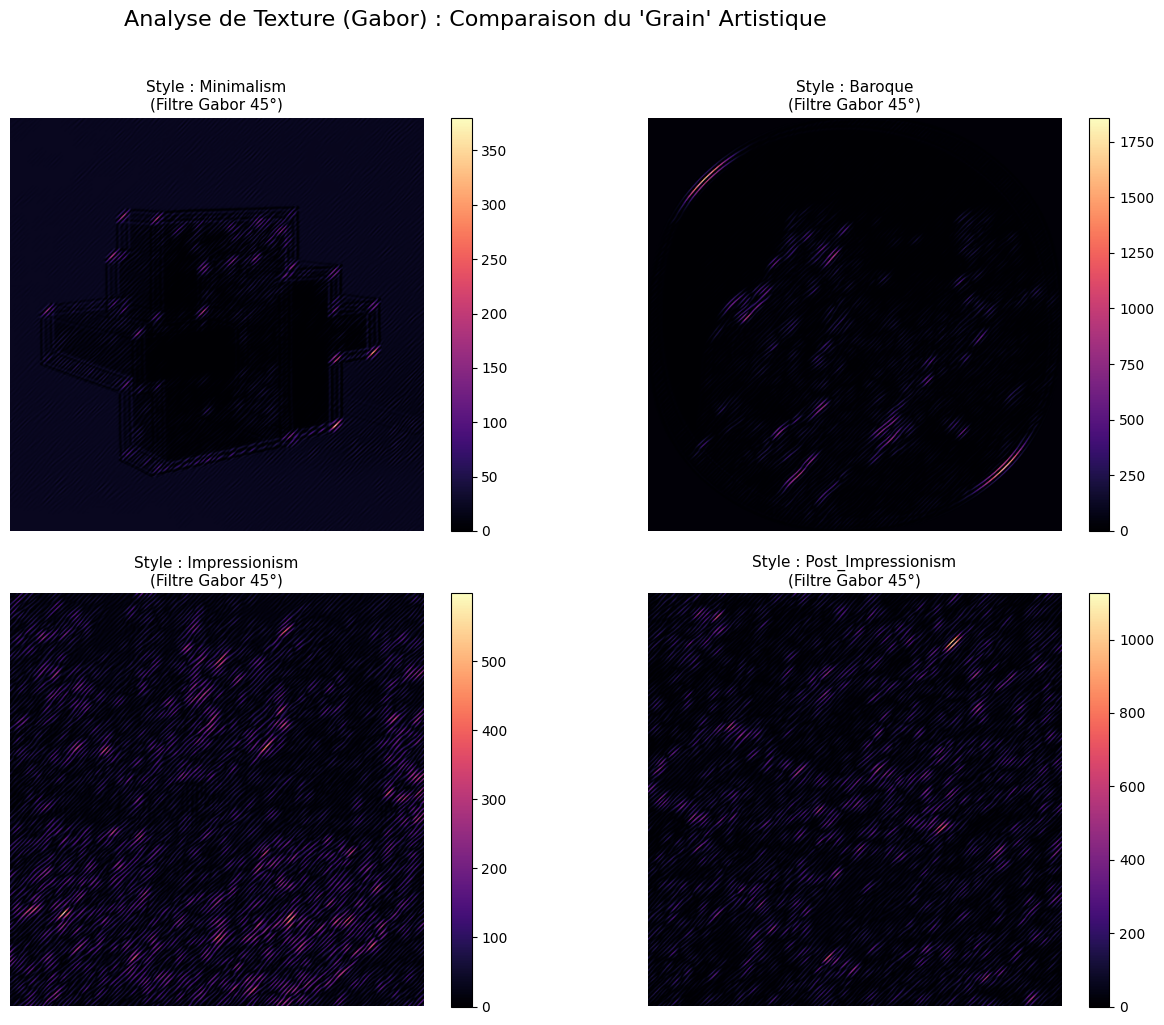

In [52]:
# Comparaison Gabor
fv_module.FrequencyVisualizer.plot_comparative_analysis(target_styles, df_analysis, analyzer, dataset_module, DATA_ROOT, mode="gabor");

Les filtres de Gabor agissent comme des détecteurs de motifs locaux. Ils simulent la manière dont le système humain perçoit les textures et les orientations. 

Un filtre de Gabor recherche à la fois : 
- une orientation (exemple 45° ici) : le filtre réagit fortement si un trait suit cet angle précis
- une échelle/fréquence : le filtre cible soit des détils fins (grain de la toile) soit des motifs plus larges (forme d'un objet) 

Interprétation : 

Minimalisme : réponse du filtre quasi-nulle sauf au niveau des contours de l'aplat de couleur central. En effet les aplats de couleur en eux même ne contiennent aucune micro-texture directionnelle. 

Baroque : on a des réponses localisées sur les contours des formes et les drapés. 

Impressionisme et Post-Impressionisme : réponse forte et présente sur la quasi totalité des tableaux. Le filtre capture très bien les touches de peinture. 

### 3. Analyse statistique exploratoire



Pour cette phase, nous utilisons un échantillon de 15 images par style (345 images au total). 

Ce choix a été fait pour :
- la clareté : on évite de surcharger les graphiques pour pouvoir bien lire les clusters et les distributions
- la rapidité d'exécution : cela va permettre de valider nos descripteurs (Fourier, Gabor) avant de passer au dataset complet pour le SVM

In [53]:
from tqdm import tqdm
features_list = []

for i, row in tqdm(df_analysis.iterrows(), total=df_analysis.shape[0]):
    try:
        # Chargement et Preprocessing
        img_pil = dataset_module.load_image(row, DATA_ROOT)
        img_np = analyzer.preprocess_image(img_pil)
        
        # Extraction 
        metrics = analyzer.extract_features_from_image(img_np)
        
        # Fusion avec les métadonnées (le style)
        features_list.append({
            "style_name": row["style_name"],
            **metrics
        })
        
    except Exception as e:
        print(f" Erreur sur l'image {i}: {e}")

df_features = pd.DataFrame(features_list)
print(f"Tableau de caractéristiques créé : {df_features.shape}")

100%|██████████| 345/345 [01:31<00:00,  3.75it/s]

Tableau de caractéristiques créé : (345, 45)


##### a. Transformée de Fourier 

**Distribution du ratio HF/BF par Style :**

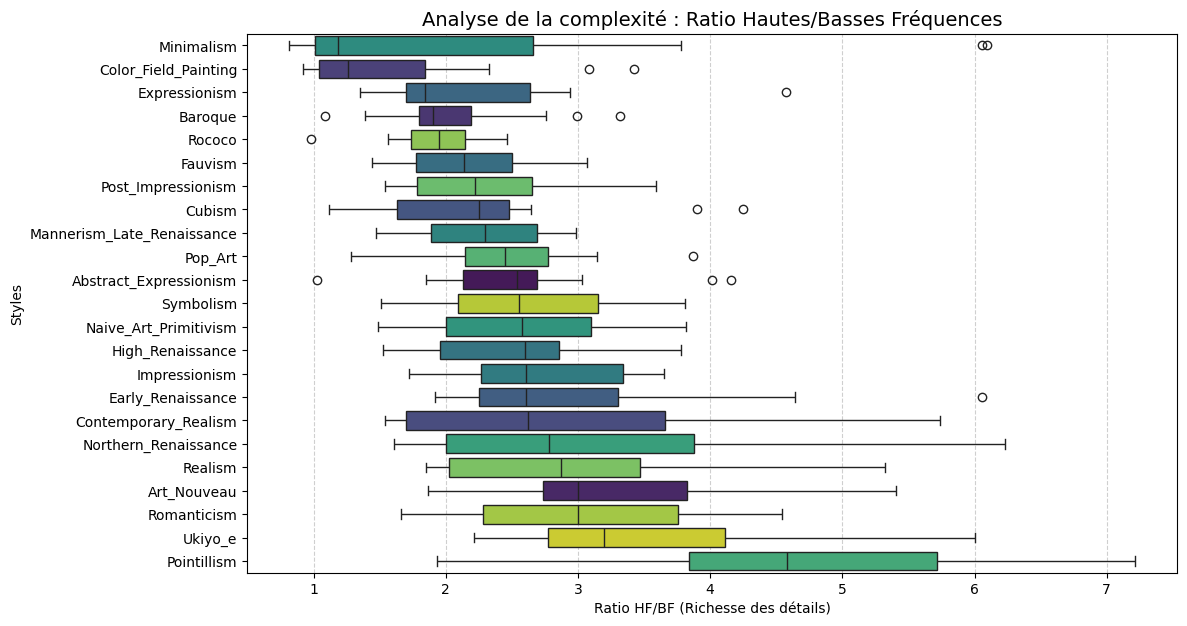

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tri des styles par ratio médian pour faciliter la lecture
order = df_features.groupby("style_name")["hf_bf_ratio"].median().sort_values().index

plt.figure(figsize=(12, 7))
sns.boxplot(data=df_features, x="hf_bf_ratio", y="style_name", order=order, hue="style_name", legend=False, palette="viridis")

plt.title("Analyse de la complexité : Ratio Hautes/Basses Fréquences", fontsize=14)
plt.xlabel("Ratio HF/BF (Richesse des détails)")
plt.ylabel("Styles")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

La médiane du box plot montre la valeur typique du style. 

Le ratio HF/BF confirme qu'il y a un lien entre complexité visuelle et courants artistiques.  
Le Minimalisme présente les ratios les plus bas (environ 1,2), traduisant une absence de détails fins au profit des formes globales.  
À l'opposé, le Pointillisme atteint les valeurs les plus hautes (environ 4,5), prouvant que l'information est concentrée dans les micro-textures.  
Entre ces deux extrêmes, les autres styles s'échelonnent, la largeur de leurs boîtes indiquant une plus ou moins grande diversité de traitement au sein d'un même mouvement.

**Profils d'énergie radiale :**

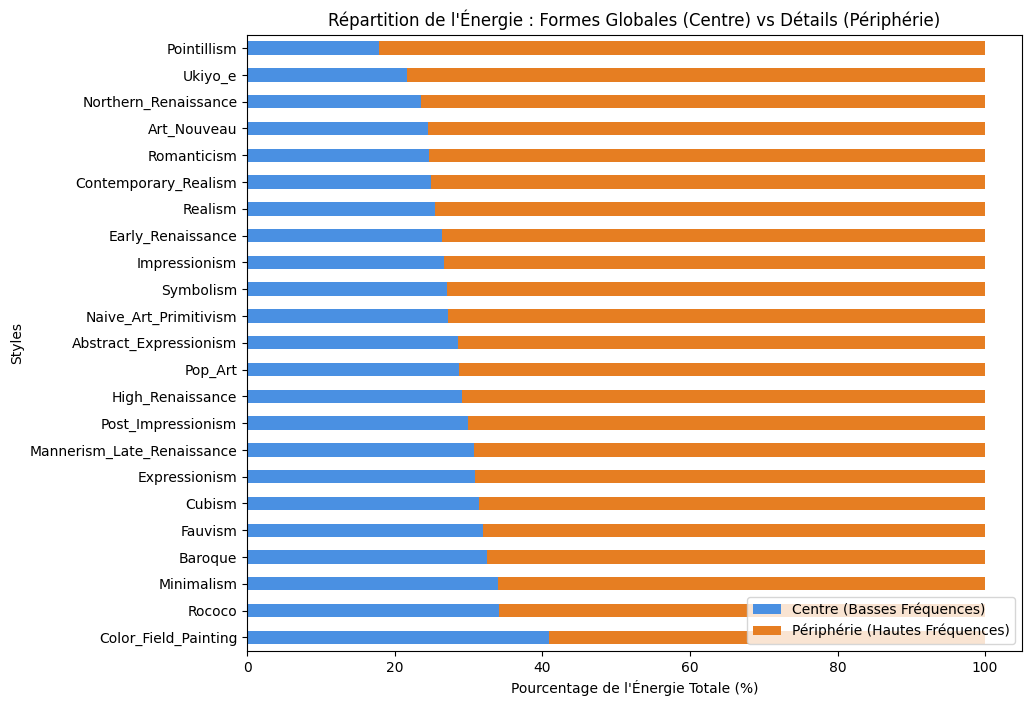

In [55]:
# Préparation des données pour un barplot comparatif
df_energy = df_features.groupby("style_name")[["energy_center", "energy_periphery"]].mean()

# On normalise pour voir la répartition relative (%)
df_energy_perc = df_energy.div(df_energy.sum(axis=1), axis=0) * 100

df_energy_perc.sort_values("energy_periphery").plot(
    kind='barh', 
    stacked=True, 
    figsize=(10, 8),
    color=['#4a90e2', '#e67e22']
)

plt.title("Répartition de l'Énergie : Formes Globales (Centre) vs Détails (Périphérie)")
plt.xlabel("Pourcentage de l'Énergie Totale (%)")
plt.ylabel("Styles")
plt.legend(["Centre (Basses Fréquences)", "Périphérie (Hautes Fréquences)"], loc='lower right')
plt.show()

Les styles avec une longues barre orange (Périphérie=haute fréquence) sont ceux qui ont le plus de micro détails. 

Ceux avec une dominance bleue sont plus épurés. 

##### b. Multi-Echelles 

**Espace énergie Passe-bas vs Passe-Haut :**

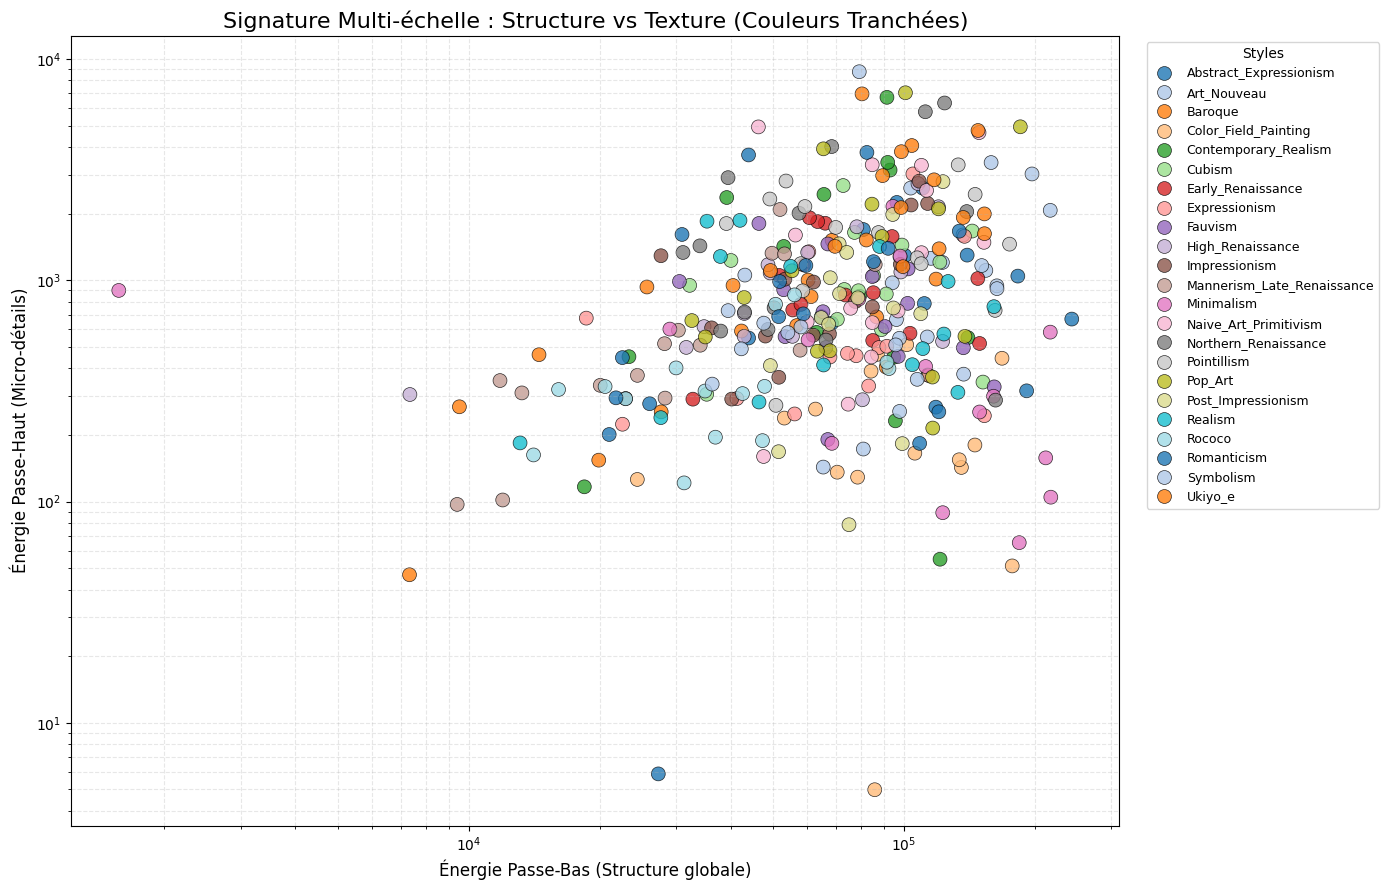

In [56]:
plt.figure(figsize=(14, 9))

sns.scatterplot(
    data=df_features, 
    x="lowpass_energy", 
    y="highpass_energy", 
    hue="style_name", 
    palette="tab20", #
    alpha=0.8,      
    edgecolor="black", 
    linewidth=0.5,
    s=100            
)

plt.xscale('log') 
plt.yscale('log')

plt.title("Signature Multi-échelle : Structure vs Texture (Couleurs Tranchées)", fontsize=16)
plt.xlabel("Énergie Passe-Bas (Structure globale)", fontsize=12)
plt.ylabel("Énergie Passe-Haut (Micro-détails)", fontsize=12)

# On place la légende à l'extérieur avec une police lisible
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="Styles", fontsize=9, ncol=1)

plt.grid(True, which="both", linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

On projette les images sur deux axes : l'intensité des structures larges ($x$) et l'intensité des détails fins ($y$). 

Normalement : 
- en haut à droite : styles complexes avec à la fois des grands contrastes et beaucoup de détails
- en bas à gauche : styles épurés, lisses


Avec nos images, nous n'arrivons pas à distinguer particulièrement des clusters. Les points sont fortement corrélés et se chevauchent massivement. Lowpass_energy et highpass_energy ne sont donc sûrment pas des bons critères pour séparer les classes. 

**Heatmap de la variance multi-échelle :**

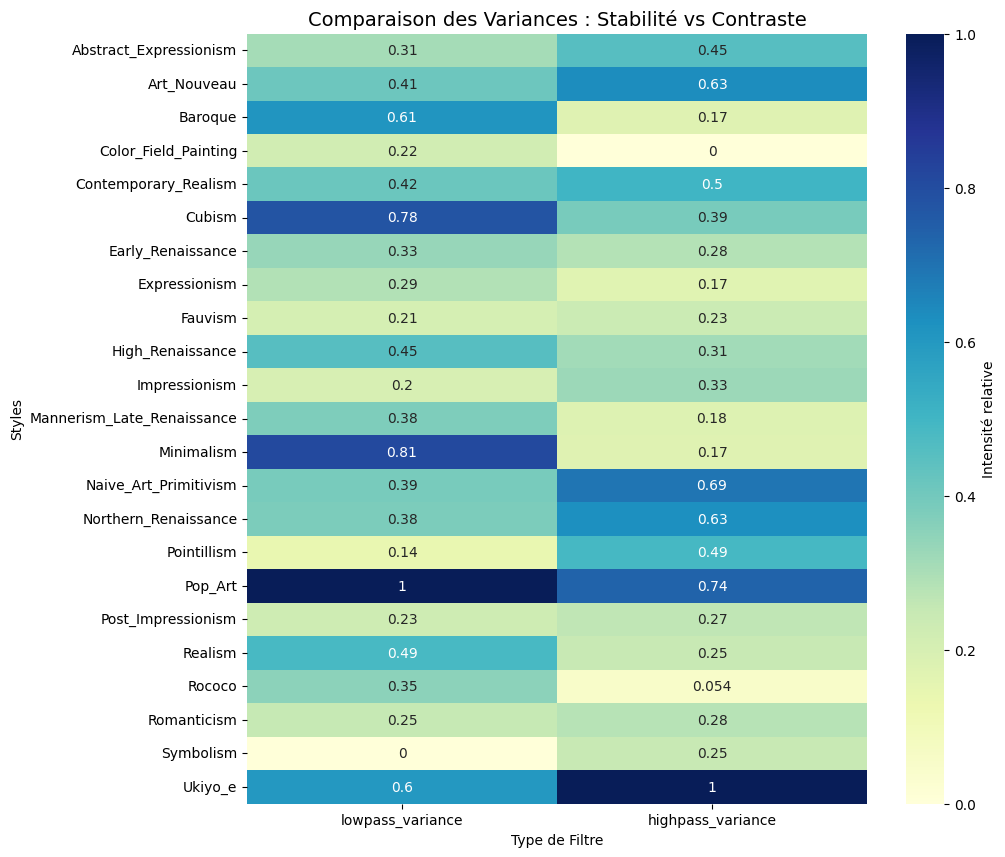

In [57]:
# Préparation des données : moyenne de la variance par style
df_var = df_features.groupby("style_name")[["lowpass_variance", "highpass_variance"]].mean()

# Normalisation par colonne pour comparer les styles entre eux (0 à 1)
df_var_norm = (df_var - df_var.min()) / (df_var.max() - df_var.min())

plt.figure(figsize=(10, 10))
sns.heatmap(df_var_norm, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Intensité relative'})

plt.title("Comparaison des Variances : Stabilité vs Contraste", fontsize=14)
plt.xlabel("Type de Filtre")
plt.ylabel("Styles")
plt.show()

La heatmap compare la variance (l'intensité du contraste) entre les structures globales (Lowpass) et les détails fins (Highpass). 

Ce que nous observons : 
- Styles à fort contraste global : Certains styles présentent des valeurs élevées sur les deux colonnes. Cela indique une dynamique visuelle forte, avec des masses de couleurs tranchées et des détails marqués.

- Styles "Lisses" ou Homogènes : D'autres styles affichent des valeurs faibles partout, signe d'une transition douce entre les couleurs et d'une absence de micro-contrastes.

- Déséquilibre : Les lignes où les deux colonnes ont des couleurs très différentes sont les plus intéressantes. Un style avec une highpass_variance élevée mais une lowpass_variance faible possède une texture vibrante et des formes très floues ou peu contrastées.

##### c. Gabor 

**Radar Chart : Directionnalité**

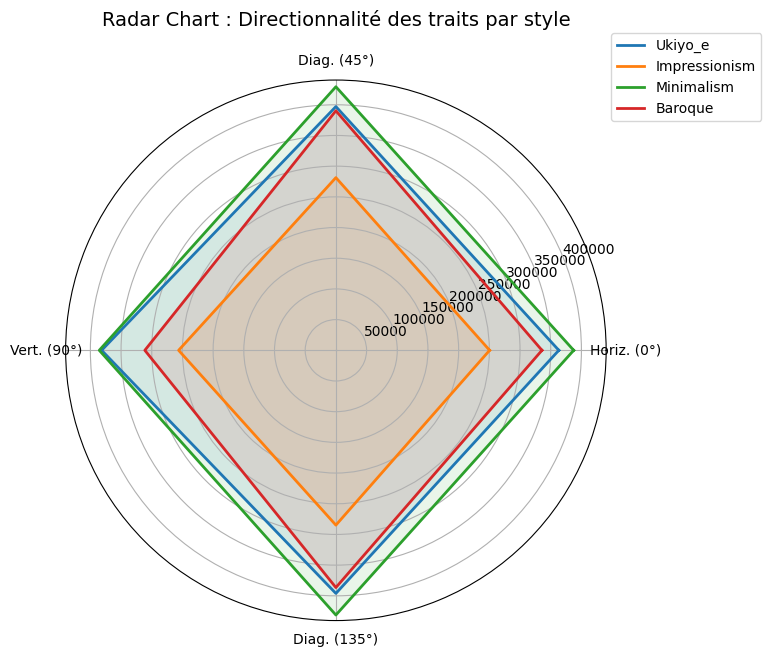

In [58]:
# Sélectionne 3-4 styles très différents pour voir le contraste
fv_module.FrequencyVisualizer.plot_gabor_radar(df_features, ["Ukiyo_e", "Impressionism", "Minimalism", "Baroque"])

Les graphiques en radar révèlent la réponse des textures selon quatre angles (0°, 45°, 90°, 135°).

Si le Losange est parfait, cela signifie que le style est isotrope (autant de traits dans tous les sens). C'est le cas de l'Impressionnisme (losange presque parfait).

Si une pointe du losange est beaucoup plus longue que les autres, c'est là qu'on a une direction privilégiée (anisotropie). 

La taille du losange, mesure la force du contraste texturale.
Le minimalisme a un plus grand radar car il possède des contours nets et des contratses brutaux, ce qui génère une variance bien plus forte que les touches plus fondues de l'Impressionnisme. 


**Boxplot de l'entropie de Gabor :**

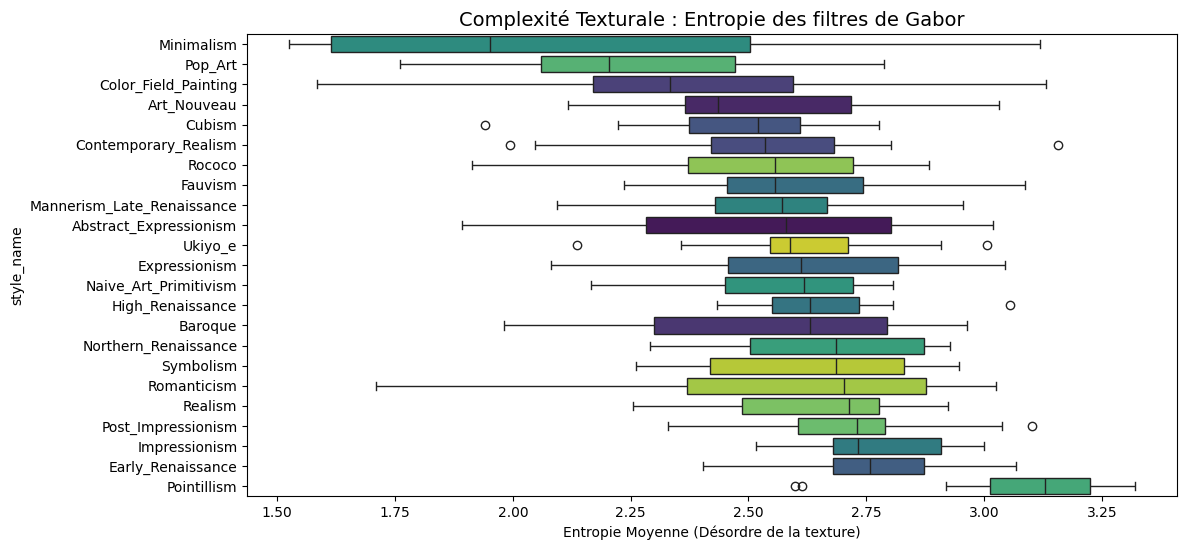

In [59]:
# On calcule l'entropie moyenne (tous angles/fréquences confondus) pour chaque image
entropy_cols = [c for c in df_features.columns if 'entropy' in c]
df_features['mean_gabor_entropy'] = df_features[entropy_cols].mean(axis=1)

plt.figure(figsize=(12, 6))
order_ent = df_features.groupby("style_name")["mean_gabor_entropy"].median().sort_values().index

sns.boxplot(data=df_features, x="mean_gabor_entropy", y="style_name", 
            order=order_ent, hue="style_name", palette="viridis", legend=False)

plt.title("Complexité Texturale : Entropie des filtres de Gabor", fontsize=14)
plt.xlabel("Entropie Moyenne (Désordre de la texture)")
plt.show()

L'entropie mesure le désordre de la texture : 
- une entropie faible montre une texture régulière répétitive. C'est le cas des styles Minimalisme, Pop Art, Color Field Painting, Art Nouveau et Cubisme.  
- une entropie élevée montre une texture cahostique, complexe (coups de pinceau très visibles). C'est le cas par exemple des styles Impressionnisme, Early Renaissance ou Pointillisme. 

##### d. PCA 

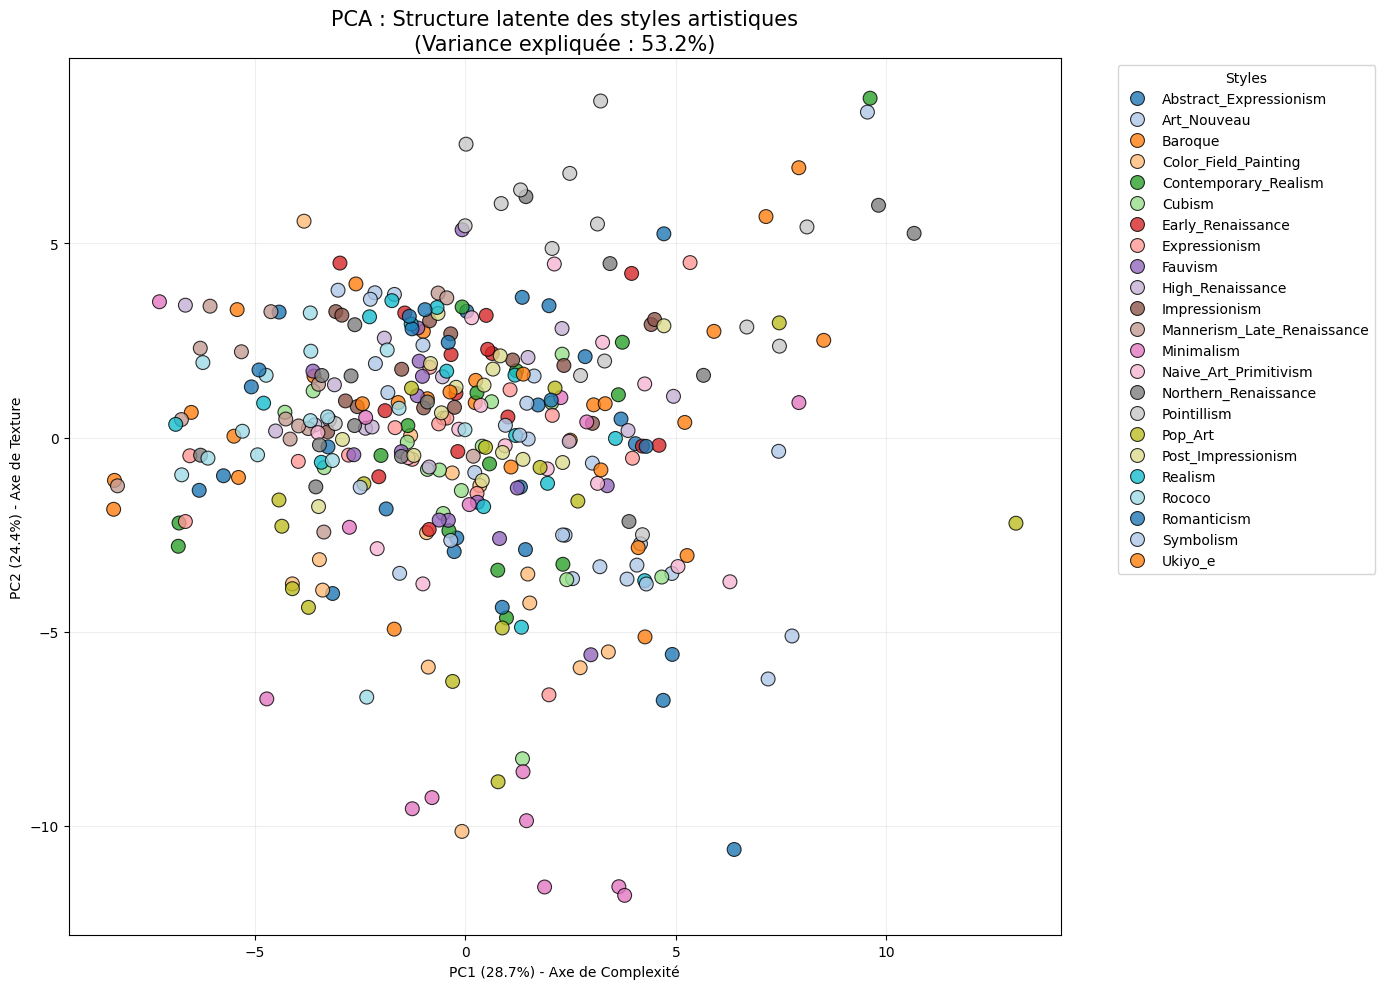

In [60]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#  Sélection des colonnes numériques et standardisation
features_cols = [c for c in df_features.columns if c not in ['style_name', 'split']]
x_scaled = StandardScaler().fit_transform(df_features[features_cols])

#Calcul de la PCA
pca = PCA(n_components=2)
coords = pca.fit_transform(x_scaled)

df_pca = pd.DataFrame(data=coords, columns=['PC1', 'PC2'])
df_pca['style_name'] = df_features['style_name'].values

# Visualisation
fv_module.FrequencyVisualizer.plot_pca(df_pca, pca.explained_variance_ratio_ * 100)

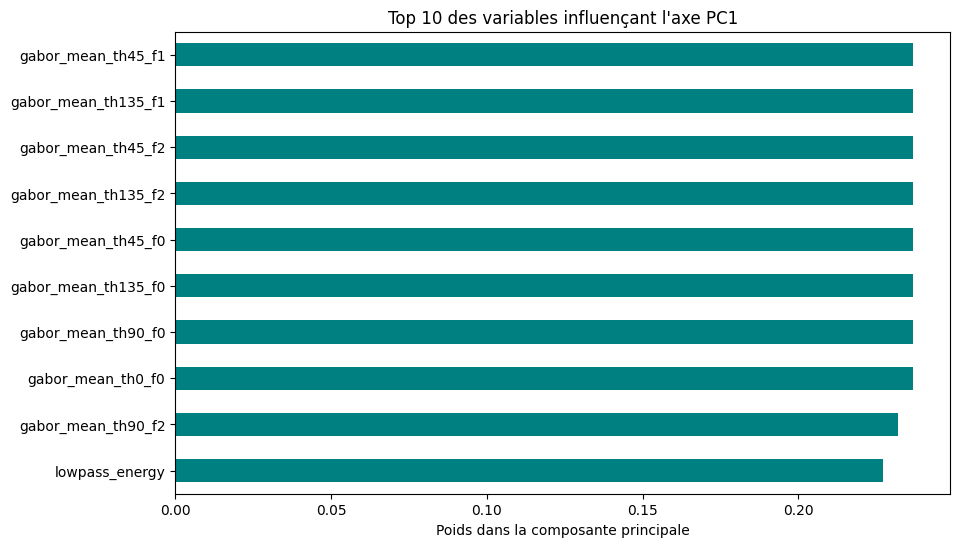

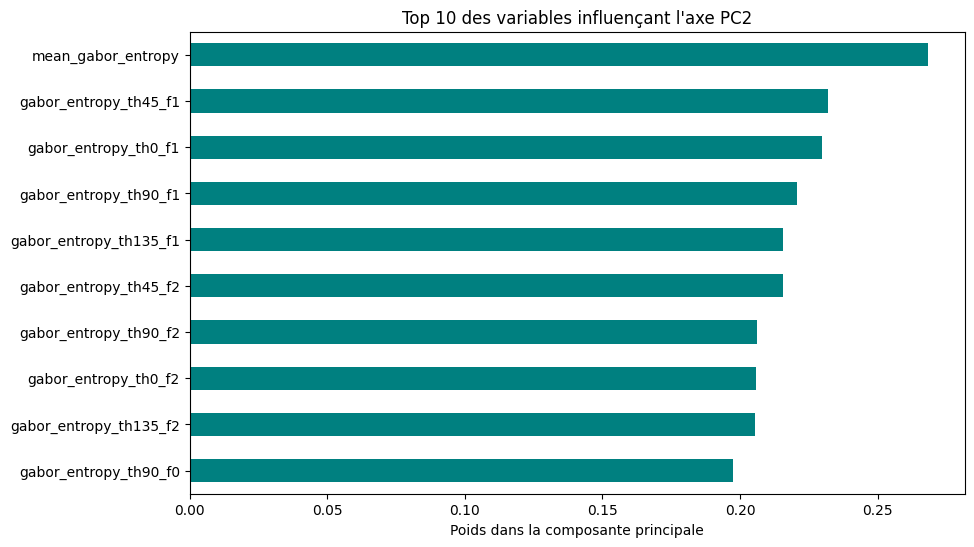

In [61]:
# Récupération des contributions (loadings)
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=['PC1', 'PC2'], 
    index=features_cols
)

# Affichage des 10 variables les plus influentes pour PC1
plt.figure(figsize=(10, 6))
loadings['PC1'].sort_values().tail(10).plot(kind='barh', color='teal')
plt.title("Top 10 des variables influençant l'axe PC1")
plt.xlabel("Poids dans la composante principale")
plt.show()

# Affichage des 10 variables les plus influentes pour PC2
plt.figure(figsize=(10, 6))
loadings['PC2'].sort_values().tail(10).plot(kind='barh', color='teal')
plt.title("Top 10 des variables influençant l'axe PC2")
plt.xlabel("Poids dans la composante principale")
plt.show()

La projection des 345 images sur les deux axes principaux (couvrant 53,2% de la variance totale) révèle une structure complexe et entremêlée.

On observe une distribution continue où les styles se chevauchent massivement. A part le Minimalisme et le Pointillisme qui sont très légèrement isolés des autres (mais éparpillés). 


On a donc de nombreux styles qui partagent des caractéristiques fréquentielles et texturales similaire. L'analyse purement mathématiques de la texture ne va certainement pas suffir à distinguer le style. Il va nous falloir compléter ces informations avec les éléments de vision classique et peut-être également le genre. 

Egalement le modèle de classification devra travailler dans un espace de haute dimension pour trouver des frontières non linéaires, car une simple séparation 2D est impossible

### 4. Pipeline d'extraction massive

In [ ]:
import os
import pandas as pd
from tqdm import tqdm

# Préparation de l'analyseur
analyzer = fa_module.FrequencyAnalyzer(target_size=(512, 512))

# Configuration des chemins (on remonte d'un cran vers /results)
output_path = "../results/final_frequency_features.csv"
log_path = "../results/extraction_errors_frequency_features.log"

# Nettoyage et création du dossier
os.makedirs("../results", exist_ok=True)
if os.path.exists(output_path): os.remove(output_path)
if os.path.exists(log_path): os.remove(log_path)

print(f"Lancement de l'extraction sur {len(df)} images.")

# Boucle sur les splits
for split in ['train', 'val', 'test']:
    # On utilise 'df' ici qui contient tout le monde
    df_split = df[df['split'] == split]
    
    if df_split.empty:
        print(f"Saut du split {split} (vide)")
        continue

    for i, row in tqdm(df_split.iterrows(), total=len(df_split), desc=f"Split {split}"):
        try:
            # Pipeline d'analyse
            img_pil = dataset_module.load_image(row, DATA_ROOT)
            img_np = analyzer.preprocess_image(img_pil)
            extracted_features = analyzer.extract_features_from_image(img_np)
            
            # Organisation des colonnes : Identifiants d'abord, puis features
            # On crée un nouveau dictionnaire pour l'ordre
            row_data = {
                'filename': row['filename'],
                'split': split,
                'style_name': row['style_name']
            }
            # On ajoute les features calculées à la suite
            row_data.update(extracted_features)
            
            # Sauvegarde itérative
            df_temp = pd.DataFrame([row_data])
            df_temp.to_csv(output_path, mode='a', index=False, header=not os.path.exists(output_path))
            
        except Exception as e:
            with open(log_path, "a") as f:
                f.write(f"Erreur Image {i} ({row['filename']}): {str(e)}\n")

print("Extraction terminée !")

Lancement de l'extraction sur 9200 images.


Split test: 100%|██████████| 1378/1378 [06:37<00:00,  3.47it/s]

Extraction terminée !


Vérification Post-Extraction :

In [26]:
# Chargement du dataset complet
df_final = pd.read_csv("../results/final_frequency_features.csv")

# Vérification des volumes
print("Répartition par split :\n", df_final['split'].value_counts())

# Détection des NaN (images corrompues ou division par zéro)
if df_final.isna().sum().sum() > 0:
    print(f" {df_final.isna().sum().sum()} valeurs manquantes supprimées.")
    df_final = df_final.dropna()

# Sauvegarde de la version propre
df_final.to_csv("../results/CSV/final_frequency_features_cleaned.csv", index=False)

Répartition par split :
 split
train    6449
test     1378
val      1373
Name: count, dtype: int64


##### Matrice de Corrélation de Pearson

On supprime les colonnes corrélées. 

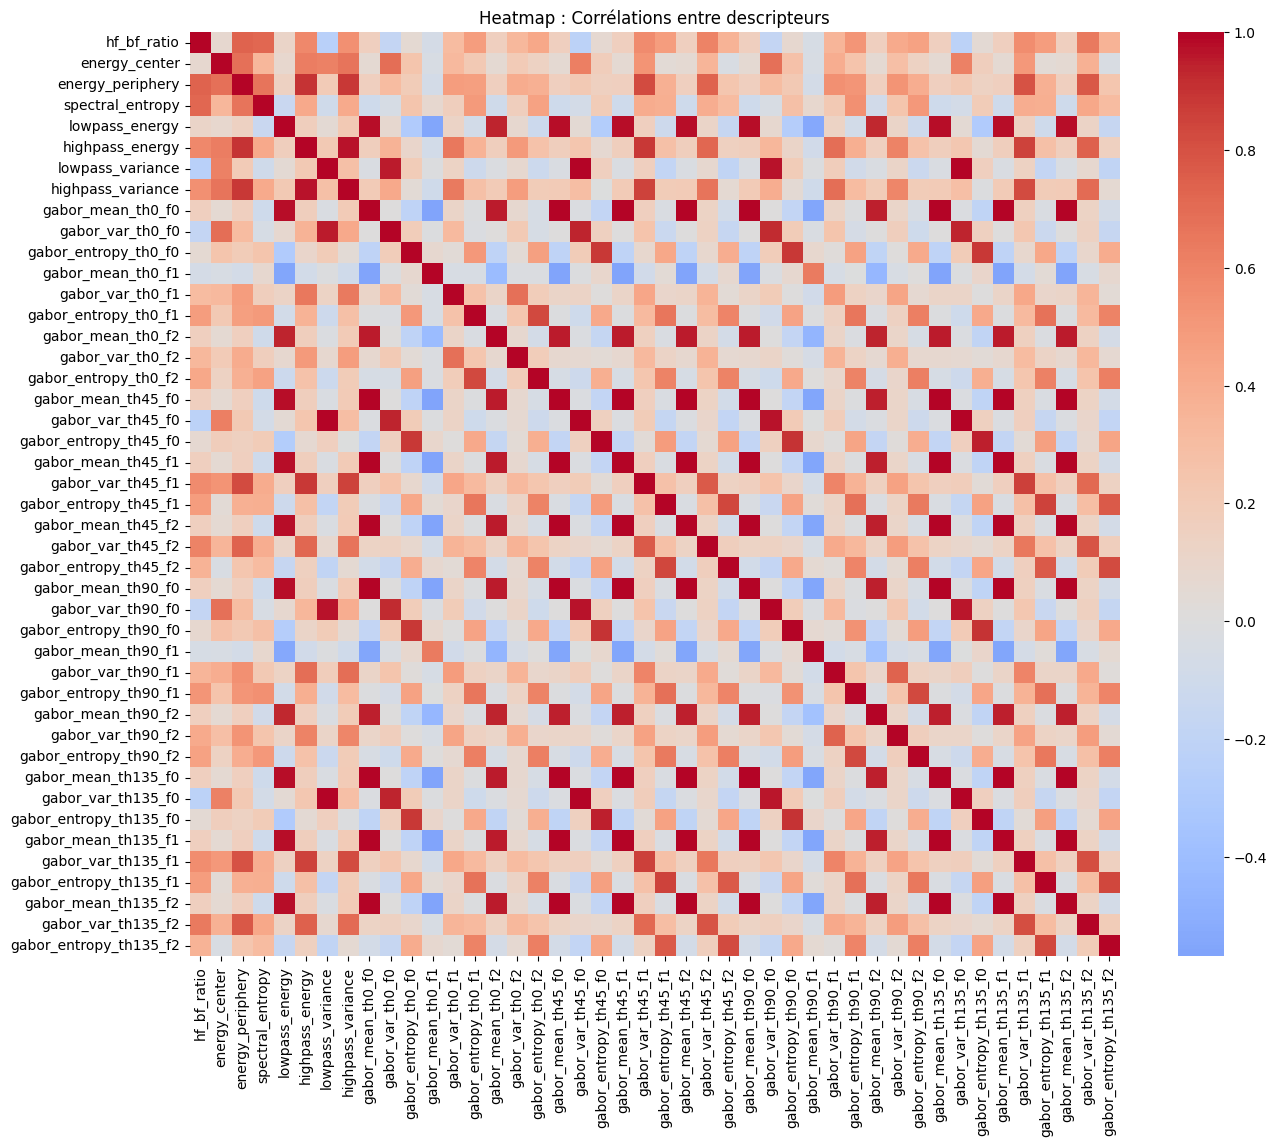

Colonnes redondantes à supprimer : ['highpass_variance', 'gabor_mean_th0_f0', 'gabor_var_th0_f0', 'gabor_mean_th0_f2', 'gabor_mean_th45_f0', 'gabor_var_th45_f0', 'gabor_mean_th45_f1', 'gabor_mean_th45_f2', 'gabor_mean_th90_f0', 'gabor_var_th90_f0', 'gabor_mean_th135_f0', 'gabor_var_th135_f0', 'gabor_mean_th135_f1', 'gabor_mean_th135_f2']


In [27]:
df_final = pd.read_csv("../results/CSV/final_frequency_features_cleaned.csv")

plt.figure(figsize=(15, 12))
corr_matrix = df_final.drop(columns=['style_name', 'split', 'filename']).corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title("Heatmap : Corrélations entre descripteurs")
plt.show()

# Code pour identifier les features à supprimer (r > 0.95)
upper = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f"Colonnes redondantes à supprimer : {to_drop}")

In [28]:
df_freq_cleaned = df_final.drop(columns=to_drop)

# Réécriture sur le fichier cleaned
df_freq_cleaned.to_csv("../results/CSV/final_frequency_features_cleaned.csv", index=False)
print(f"Nombre de colonnes avant la supression des colonnes redondantes : {len(df_final.columns)}")
print(f"Nombre de colonnes après la supression des colonnes redondantes : {len(df_freq_cleaned.columns)}")

Nombre de colonnes avant la supression des colonnes redondantes : 47
Nombre de colonnes après la supression des colonnes redondantes : 33


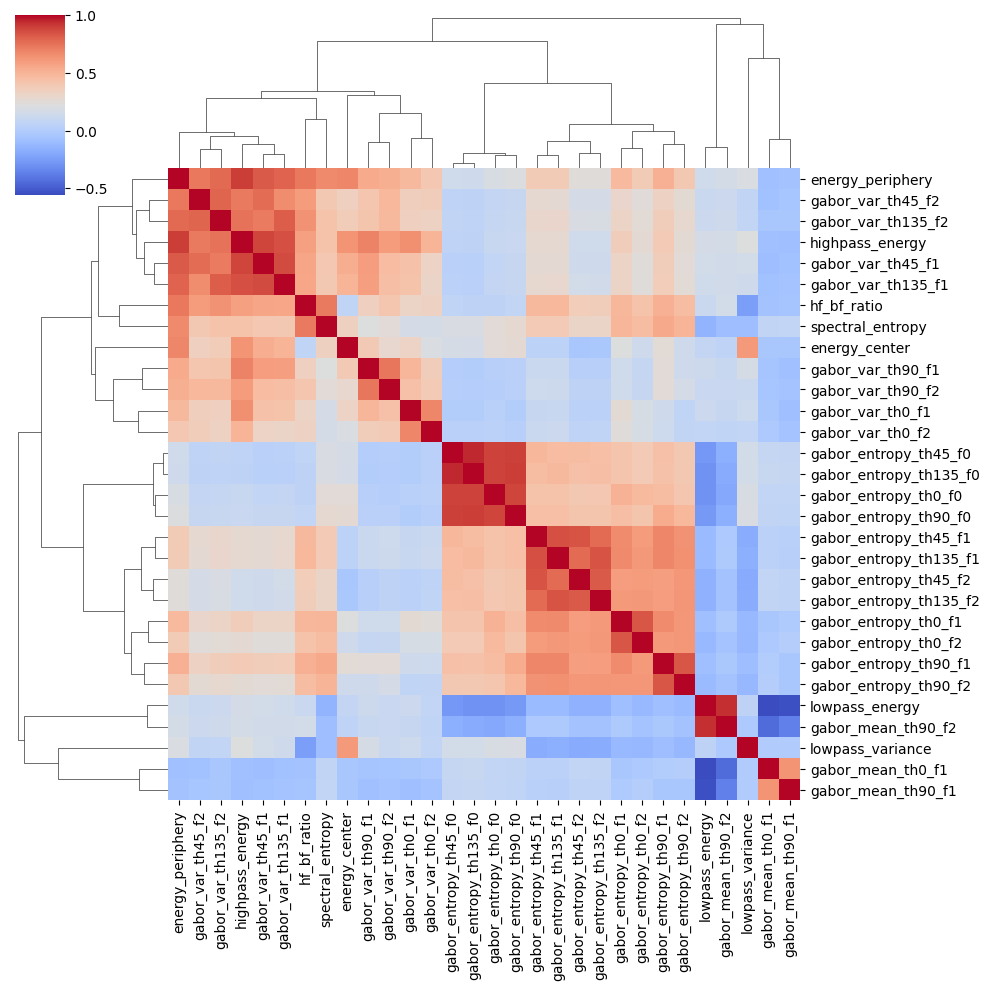

In [29]:
# Cluster Map pour voir les signatures de styles
df_num = df_freq_cleaned.drop(columns=['style_name', 'split', 'filename'])
sns.clustermap(df_num.corr(), cmap='coolwarm', figsize=(10, 10))
plt.show()

L'analyse de la cluster map révèle une forte corrélation entre les différentes orientations de l'entropie de Gabor : une entropie élevée dans une direction implique généralement une complexité similaire dans les autres axes. Sur le plan artistique, cela traduit le fait qu'une œuvre fortement texturée présente souvent des reliefs et des micro-textures multidirectionnels.

Pour optimiser notre modèle sans perdre d'information essentielle, nous avons choisi de ne conserver que la moyenne, la variance et l'entropie pour deux orientations stratégiques : l'axe vertical 0° et l'axe diagonal 45°, et ce, sur deux échelles différentes. Ce choix est motivé par une logique stylistique : l'orientation à 0° permet de capturer la rigueur des styles géométriques (Cubisme, Minimalisme), tandis que la diagonale à 45° est plus discriminante pour identifier le dynamisme et la richesse des touches de pinceau propres aux mouvements plus expressifs

In [31]:
df_freq = pd.read_csv("../results/CSV/final_frequency_features_cleaned.csv")

to_keep = [
    'filename', 'split', 'style_name',
    # Bloc Fourier (Vision Globale)
    'hf_bf_ratio', 'spectral_entropy', 
    'energy_center', 'energy_periphery', # <--- Réintégrés ici
    'highpass_energy', 'lowpass_energy', 
    'lowpass_variance',
    
    # Bloc Gabor (Texture Locale & Orientation)
    # Échelle 1 (f1)
    'gabor_mean_th0_f1', 'gabor_var_th0_f1', 'gabor_entropy_th0_f1',
    'gabor_mean_th45_f1', 'gabor_var_th45_f1', 'gabor_entropy_th45_f1',
    # Échelle 2 (f2)
    'gabor_mean_th0_f2', 'gabor_var_th0_f2', 'gabor_entropy_th0_f2',
    'gabor_mean_th45_f2', 'gabor_var_th45_f2', 'gabor_entropy_th45_f2'
]

df_freq_final = df_freq[[c for c in to_keep if c in df_freq.columns]]
df_freq_final.to_csv("../results/CSV/final_frequency_features_minimal.csv", index=False)